## Visualizing Fire Scars through False Color
Author: Joaquin Sandoval 

Github repository: https://github.com/sandovaljoaquin/eaton-palisades-fire-analysis



![](img/fires.png)
Overview of Palisades and Eaton Wildfires in a satellite image provided by MaxarTechnologies.


## About 

The Eaton and Palisades Fires occured in Janurary 2025 in Los Angeles County and were some of the most devastating in California history. These two fires scorched a combined amount of 37,469 acres and destroyed or damaged an estimated 18,298 structures (Cal Fire). The following analyses will enable visualization of the fire scar left behind using remote sensing data and investigate if minority groups were disproportionately affected. 

### Highlights : 
- Fire perimeter boundary data import and exploration. 
- Landsat data import and exploration as an `xarray.Dataset`.
- Restoring geospatial information to an `xarray.Dataset`.
- Plotting a True-Color Image and False Color Image with fire perimeter boundaries. 
- Cropping census tract data from EJI to the fire boundaries.
- Plotting estimated minority % of cenus tracts within each fire boundary.


### About the data: 

There are three datasets used in this analysis. 

(1) `eaton_boundary`: layer contains dissolved fire perimeter/boundary for Eaton Fire. 
(01/21/2025)

(2) `palisades_boundary`: layer contains dissolved fire perimeter/boundary for Palisades Fire. (01/21/2025)

(3) `landsat`: simplified collection of bands (red, green, blue, near-infrared, and shortwave infrared) from the Landsat Collection 2 Level-2 atmospherically correxted surface reflected data collected by the Landsat 8 satellite. This data was clipped to an area of Los Angeles County to include both fire perimeters.

(4) `eji_california`: 2024 Environmental Justice Index data for California in the geodatabase data format.

### References: 

[1] and [2]: 

Credit: NIFC FIRIS
The source of the hosted service/dataset is here
https://services1.arcgis.com/jUJYIo9tSA7EHvfZ/ArcGIS/rest/services/CA_Perimeters_NIFC_FIRIS_public_view/FeatureServer

[3] Microsoft Planetary Computer. (n.d.). Landsat C2 L2. Microsoft Planetary Computer. Retrieved November 19, 2025, from https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

[4] Centers for Disease Control and Prevention and Agency for Toxic Substances Disease Registry. [Year] Environmental Justice Index. Accessed [Insert Date]. https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html

## Begin Visualization 

Import necessary packages.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr 
import contextily as ctx

## Fire perimeter Data Exploration

Import both perimeters for the Eaton and Palisades Fires and perform preliminary data analysis. This analysis should include each dataset's CRS, datum, and whether it is projected or geographic. 

In [2]:
# Import perimeter of eaton fire 
fp = os.path.join("data", "Eaton_Perimeter_20250121", "Eaton_Perimeter_20250121.shp")
eaton_boundary = gpd.read_file(fp)

# Import perimeter of palisades fire 
fp = os.path.join("data", "Palisades_Perimeter_20250121", "Palisades_Perimeter_20250121.shp")
palisades_boundary = gpd.read_file(fp)

In [3]:
# Examine CRS details of `eaton_boundary`
print(f"CRS of eaton_boundary: {eaton_boundary.crs}")
print('Datum', eaton_boundary.crs.datum)
print('Is geographic?', eaton_boundary.crs.is_geographic)
print('Is projected?', eaton_boundary.crs.is_projected)

CRS of eaton_boundary: EPSG:3857
Datum World Geodetic System 1984 ensemble
Is geographic? False
Is projected? True


In [4]:
# Examine CRS details of `palisades_boundary`
print(f"CRS of palisades_boundary: {palisades_boundary.crs}")
print('Datum', palisades_boundary.crs.datum)
print('Is geographic?', palisades_boundary.crs.is_geographic)
print('Is projected?', palisades_boundary.crs.is_projected)

CRS of palisades_boundary: EPSG:3857
Datum World Geodetic System 1984 ensemble
Is geographic? False
Is projected? True


## NetCDF Data Import and Exploration

Import the landsat dataset as an `xarray.Dataset` and perform preliminary exploration. Identify the variables, dimensions, and coordinates of the `xarray.Dataset`

In [5]:
# Import landsat data using `xr.open_dataset()`
landsat = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

In [6]:
landsat.head()

<xarray.Dataset> Size: 596B
Dimensions:      (y: 5, x: 5)
Coordinates:
  * y            (y) float64 40B 3.799e+06 3.799e+06 ... 3.799e+06 3.799e+06
  * x            (x) float64 40B 3.344e+05 3.344e+05 ... 3.345e+05 3.345e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 100B ...
    green        (y, x) float32 100B ...
    blue         (y, x) float32 100B ...
    nir08        (y, x) float32 100B ...
    swir22       (y, x) float32 100B ...
    spatial_ref  int64 8B ...

Dimensions: 

(y:5, x:5). The xarray dataset is a 5 x 5 grid defining the shape of the xarray dataset. 

 Coordinates:

x, y: coordinate values for the grid axis. 

time : spatial coordinate for the temporal axis of the xarray dataset.

spatial_ref : spatial reference information which contains no data. This will be solved in the following step of the notebook. 

Data varibales: 

red, green, blue: visible spectral bands 
nir08:  near-infrared band
swir22: short-wave infrared band 

## Restoring Geospatial Information

The next section of this notebook will focus on restoring the geospatial information of the xarray dataset. This will involve obtaining the CRS using the `spatial_ref.crs_wkt`attribute and then adding it back to the xarray dataset.

In [7]:
# Using rio.crs to print CRS of the dataset
print(landsat.rio.crs)

None


In [8]:
# Geospatial information for dataset stored in `spatial_ref`
# Print CRS of `landsat` by accessing `spatial_ref.crs_wkt` attribute
print(landsat.spatial_ref.crs_wkt)

PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]


In [9]:
# Recover geospatial information by using `rio.write_crs()` and the spatial reference information 
landsat = landsat.rio.write_crs(landsat.spatial_ref.crs_wkt)

In [10]:
# Print the  CRS of updated `landsat` dataset 
print(landsat.rio.crs)

EPSG:32611


## True Color Image 
With `landsat` now containing geospatial information, it can be plotted. To plot a true color image, the r,g,b bands have to be selected from the dataset. Use plot.imshow() to display raster data.

In [11]:
landsat

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


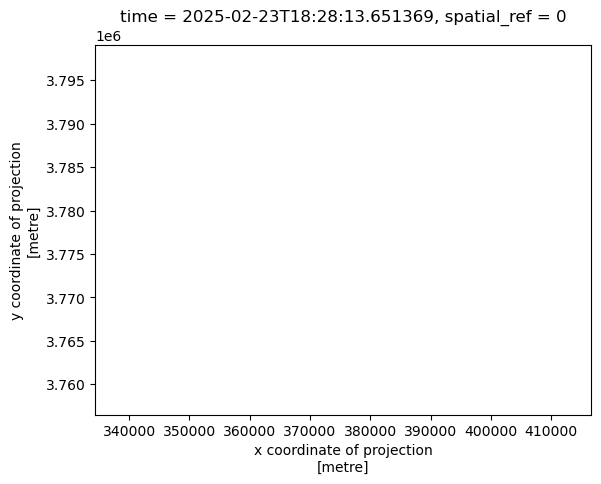

In [12]:
# Select the red, green, and blue variables of the xarray.Dataset holding the Landsat data

landsat[['red','green','blue']].to_array().plot.imshow()


The above plot is empty. The plot.imshow() arguments of vmax and robust need to be changed and nan values need to be removed from the xarray data set. Check each band to see if there are nans present and remove if so.

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


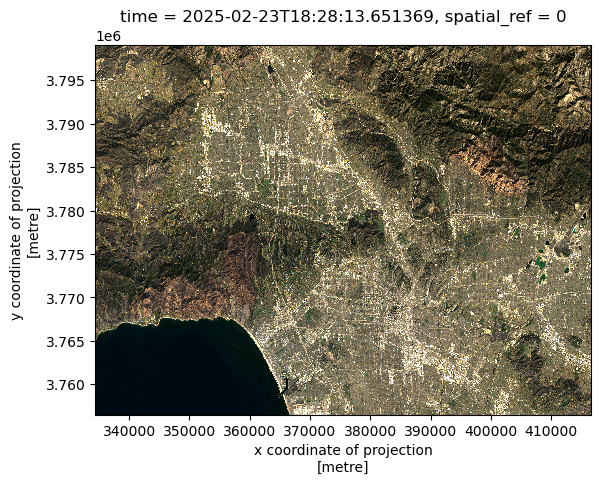

In [13]:
# Adjust the scale used for plotting the bands to get a true color image
landsat[['red','green','blue']].to_array().plot.imshow(robust = True)

In [14]:
# Check if red band has nan values
np.isnan(landsat['red']).any()

<xarray.DataArray 'red' ()> Size: 1B
array(False)
Coordinates:
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int64 8B 0

In [15]:
# Check if green band has na values 
np.isnan(landsat['green']).any()

<xarray.DataArray 'green' ()> Size: 1B
array(True)
Coordinates:
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int64 8B 0

In [16]:
# Check if blue band has nan values 
np.isnan(landsat['blue']).any()

<xarray.DataArray 'blue' ()> Size: 1B
array(True)
Coordinates:
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int64 8B 0

Plot the true color image with `landsat` with no nans.

In [17]:
# Using .fillna() to substitute the nan values with 0 
landsat['green'] = landsat['green'].fillna(0)
landsat['blue'] = landsat['blue'].fillna(0)

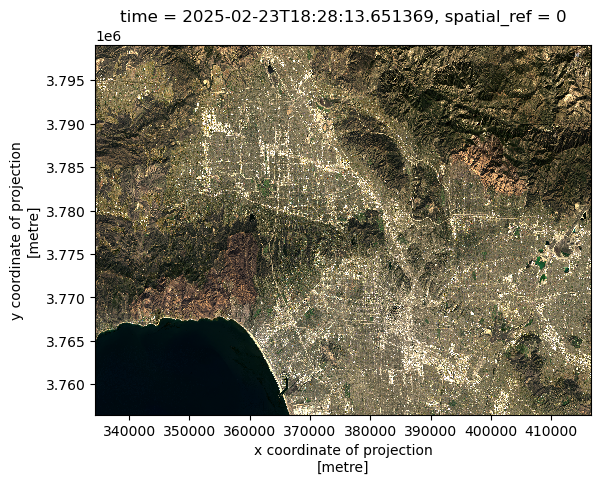

In [18]:
# Plot new true color image without warnings 
landsat[['red','green','blue']].to_array().plot.imshow(robust = True)

 Comparing the ouputs for parts (a) and (e).

The output of part (a) had the correct window; y and x coordinates of projection, but did not have any data from the red, green, or blue bands plotted. It had the following warnings: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

invalid value encountered in cast xx = (xx * 255).astype(np.uint8)

The output of part (e) had the correct window and plotted the rgb values after setting the robust paramter equal to true and removing nan values. 

##  False Color Image

Plot the false color image of `landsat` by selecting the short-wave infrared, near-wave infrared, and red bands in this order.

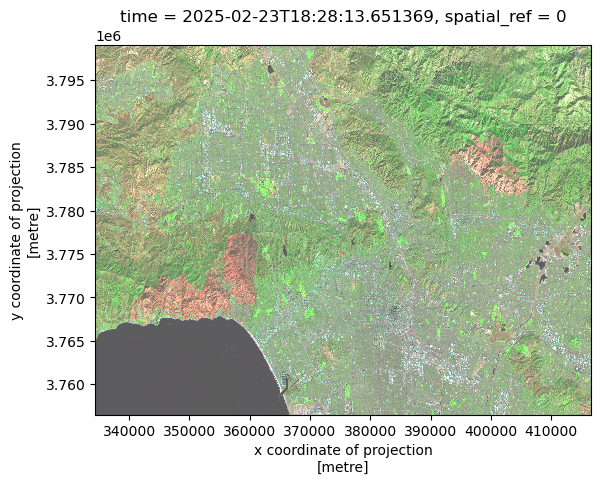

In [19]:
# Plot false color image with short-wave infared, near-infared, and red variables 
landsat[['swir22','nir08','red']].to_array().plot.imshow(vmin = 0, 
                                                       vmax = 20000, 
                                                       robust = True)

## Plot Fire Perimeters over False-color Image

Plot the false color image generated along with both `eaton_boundary` and `palisades_boundary`. `landsat` has a different crs than both boundaries. Convert the CRS of the boundary data to the CRS if the landsat data.

In [20]:
# Convert  to CRS of both fire boundaries to landsat CRS

eaton_boundary = eaton_boundary.to_crs(landsat.rio.crs)
palisades_boundary = palisades_boundary.to_crs(landsat.rio.crs)


(334395.0, 416655.0, 3756525.0, 3799065.0)

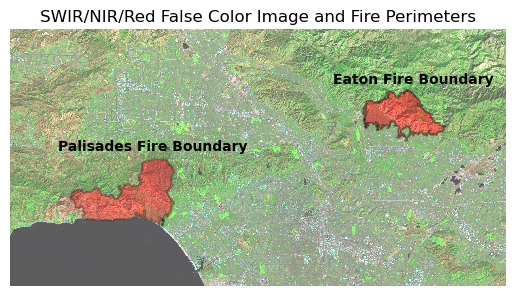

In [21]:
# Shortwave infrared/near-infrared/red false color image together with both fire perimeters
fig, ax = plt.subplots()

landsat[['swir22','nir08','red']].to_array().plot.imshow(vmin = 0, 
                                                       vmax = 20000, 
                                                       robust = True)
                                                      

eaton_boundary.plot(ax=ax,         
                 edgecolor='black',
                 color = 'red',
                 linewidth=1.25, 
                 alpha = .4)

palisades_boundary.plot(ax=ax,        
                edgecolor = 'black',
                color = 'red',
                linewidth= 1.25, 
                alpha = .3)

plt.figtext(x = .63, 
            y = .65,
            s ="Eaton Fire Boundary", 
            weight = 'bold')

plt.figtext(x = .2, 
            y = .51,
            s ="Palisades Fire Boundary", 
            weight = 'bold')
ax.set_title("SWIR/NIR/Red False Color Image and Fire Perimeters")
ax.axis('off')


The above map shows the false color image generated when selecting the short-wave infrared, near-wave infrared, and red bands from the landsat data and plotting. The boundaries of both fires were overlayed the explicit scar that was revealed from the false color image. False color imagery combines visible wavelength(s) and non-visble wavelength(s) to create satellite images that make differences in land composition more obvious. In this case, the fire scars exhibited an orange color while unscorched areas exhibited green or neutral colors. 

## Social Dimensions Analysis with the EJI Dataset

In [22]:
# Import perimeter of eaton fire 
fp = os.path.join("data", "Eaton_Perimeter_20250121", "Eaton_Perimeter_20250121.shp")
eaton_boundary = gpd.read_file(fp)

# Import perimeter of palisades fire 
fp = os.path.join("data", "Palisades_Perimeter_20250121", "Palisades_Perimeter_20250121.shp")
palisades_boundary = gpd.read_file(fp)

# Import CA EJI gdb 
fp = os.path.join("data", "EJI_2024_California", "EJI_2024_California.gdb")
eji_california = gpd.read_file(fp)

## Visualize Extent of Fires over Los Angeles County 

Plot the Palisades and Eaton fires over an open street map to visualize the areas of Los Angeles County that were affected. The CRS of both boundaries is the same so there is no need for manipulation at this point.

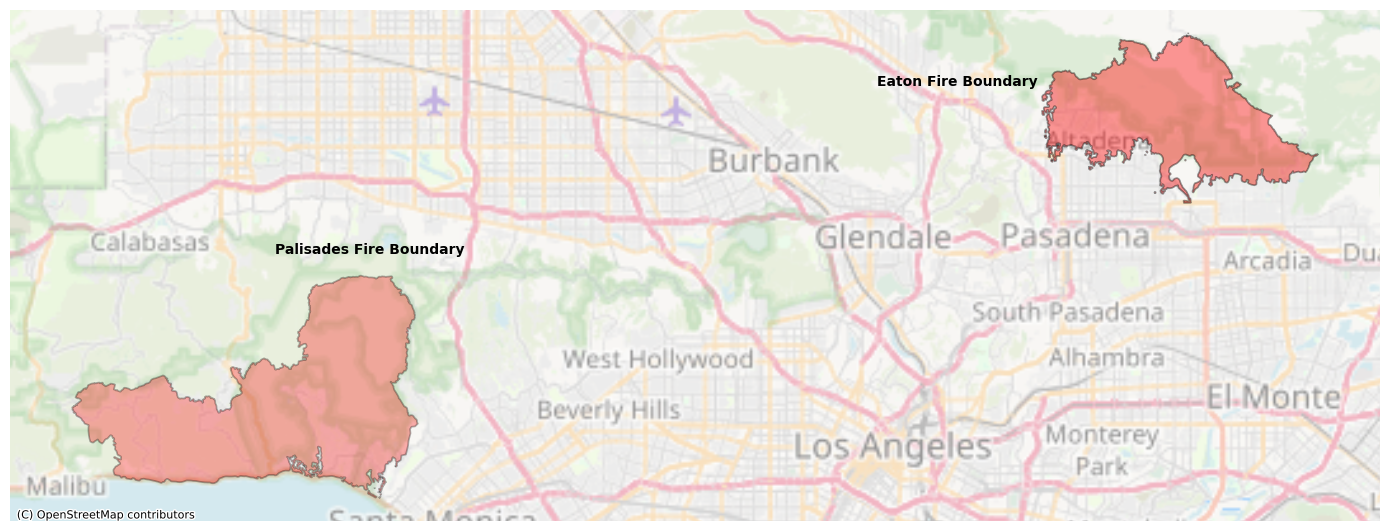

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# ADD FIRE PERIMETERS: UPDATE FILL TRANSPARENCY AND COLOR

palisades_boundary.plot(ax=ax,        
                edgecolor = 'black',
                color = 'red',
                linewidth= 1.25, 
                alpha = .3)

eaton_boundary.plot(ax=ax,         
                 edgecolor='black',
                 color = 'red',
                 linewidth=1.25, 
                 alpha = .4)

# ADD LEGEND OR ANNOTATION TO IDENTIFY EACH FIRE
plt.figtext(x = .63, 
            y = .65,
            s ="Eaton Fire Boundary", 
            weight = 'bold')

plt.figtext(x = .2, 
            y = .51,
            s ="Palisades Fire Boundary", 
            weight = 'bold')
# ADD TITLE

# Add basemap using contextily

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, 
                alpha = .5)

ax.axis('off')

plt.tight_layout()
plt.show()

The above image shows fire perimeters over a base map of Los Angeles and surrounding cities. The Palisades Fire occured between Malibu, Calabasas, and Santa Monica. The Eaton Fire occured in Altadena, just north of Pasadena. 

## Process EJI data 

Plot the boundaries of each fire with census tracts that were affected. This will allow for the analysis with an EJI variable. To investigate if minority groups were disproportionately affected, select 'E_MINRTY' as variable of interest.

 As always, the CRS of the fire perimeter data and EJI data must be consistent.

In [24]:
# Convert the CRS of eji_california to the CRS of palisades_boundary 

eji_california = eji_california.to_crs(palisades_boundary.crs)

To investigate census tracts affected in each fire, use `gpd.clip` to clip to boundary size. 

In [25]:
# Clip the shape of eji_california to that of the each fire boundary

eji_palisades_clipped = gpd.clip(eji_california, palisades_boundary)

eji_eaton_clipped = gpd.clip(eji_california, eaton_boundary)

`eji_palisades_clipped` and `eji_eaton_clipped` now contain each cenus tract within the boundaries of both fires. 

## Plot Estimated Minority % of Fire Boundary Cenus Tracts

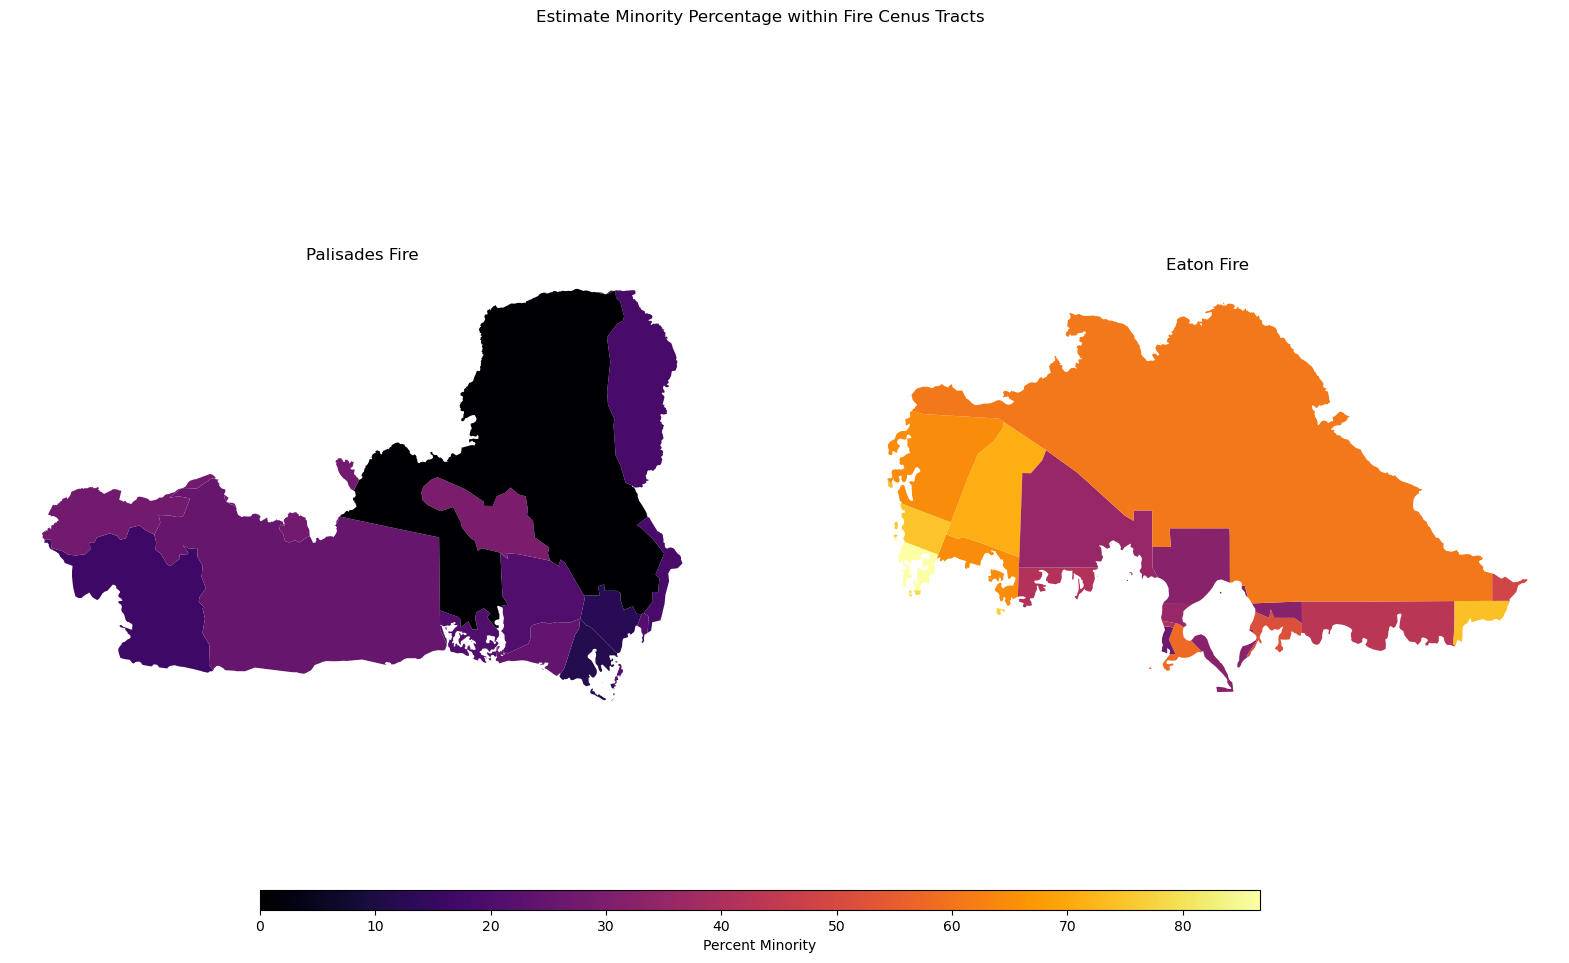

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Estimate minority % variable 
eji_variable = 'E_MINRTY'

# Find common min/max for legend range
vmin = min(eji_palisades_clipped[eji_variable].min(), eji_eaton_clipped[eji_variable].min())
vmax = max(eji_palisades_clipped[eji_variable].max(), eji_eaton_clipped[eji_variable].max())

# Plot census tracts within Palisades perimeter
eji_palisades_clipped.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
    cmap = 'inferno'
)
ax1.set_title('Palisades Fire')
ax1.axis('off')

# Plot census tracts within Eaton perimeter
eji_eaton_clipped.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
    cmap= 'inferno'
)
ax2.set_title('Eaton Fire')
ax2.axis('off')

# Add overall title
fig.suptitle('Estimate Minority Percentage within Fire Cenus Tracts')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap = 'inferno')
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

cbar.set_label('Percent Minority')

plt.show()

This image shows two choropleth maps comparing the racial/ethnic minority percentage within the boundaries of the Palisades Fire (left) and the Eaton Fire (right).

Palisades Fire area: Most tracts are in the lowest percent-minority range (very dark colors near black and purple), indicating a predominantly non-minority population.

Eaton Fire area: Census tracts show much higher minority percentages (yellow, orange, red), indicating a predominantly minority population across most of the fire zone.

Overall, the visualization highlights a strong demographic contrast between the two fire-affected regions. 